## Create environment

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from typing import List, Dict, Any, NoReturn, Tuple, Optional
import numpy as np
import pandas as pd
import glob
import os
import cv2
import xml
import re
import json
import decimal
from pprint import pprint
from collections import defaultdict

from pathlib import Path
from tqdm import tqdm
from itertools import chain

from PyQt5.QtWidgets import QApplication, QWidget

In [3]:
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline

In [4]:
ROOT_DIRECTORY = ".."
GENERAL_DATA_DIRECTORY = Path('.')
BEZIERS_LIB_DIRECTORY = Path(ROOT_DIRECTORY) / 'beziers'
DATASET_DIRECTORY = GENERAL_DATA_DIRECTORY / 'curves'

In [5]:
# Beziers
import sys
# sys.path.insert(0, '..')
import beziers

from beziers.point import Point
from beziers.path import BezierPath
from beziers.cubicbezier import CubicBezier
from beziers.quadraticbezier import QuadraticBezier
from beziers.path.representations.Nodelist import Node

## PyQt5 Window Example

PyQt Designer: C:\Users\airen\Anaconda3\envs\pycharmenv\Library\bin

In [6]:
# app = QApplication(sys.argv)

# w = QWidget()
# w.resize(250, 150)
# w.move(300, 300)
# w.setWindowTitle('Simple')
# w.show()

# sys.exit(app.exec_())

## Load dataset with curves

In [6]:
curves_df = pd.read_csv(str(DATASET_DIRECTORY / 'curves_df.csv'), sep=';', index_col=0, encoding='utf-8-sig')
print("Shape: ",curves_df.shape)
print("Unique curves in dataset: ", curves_df.c_id.nunique())

curves_df.head(2)

Shape:  (10, 1210)
Unique curves in dataset:  10


,c_id,num_knots,as_svg,as_nodes,num_segments,curve_lenght,noise_mu,noise_sigma,noise_beta,outliers_frac,...,295_x,295_y,296_x,296_y,297_x,297_y,298_x,298_y,299_x,299_y
0,0,10,M 19.000000 251.000000 C 217.194522 140.205735...,"[<x=19.0 y=251.0 curve>, <x=217.1945220425278 ...",9,1949.978296,"(19, 22)",1,0.13,0.2,...,20.567469,223.632845,17.046201,267.081185,10.045687,269.202774,8.565959,269.927917,41.529047,271.586891
1,1,10,M 147.000000 363.000000 C 148.666667 382.66666...,"[<x=147.0 y=363.0 curve>, <x=148.6666666666666...",8,2038.461343,"(19, 22)",1,0.13,0.2,...,123.017050,286.069468,547.000000,345.000000,138.915699,319.655040,180.000000,79.000000,156.042732,360.774913


In [7]:
curves_df = curves_df.drop(list(curves_df.filter(regex=("[\d]+_")).columns) + 
                           list(curves_df.filter(regex=("[\d]+c_*")).columns) + 
                           ['noise_mu', 'noise_sigma', 'noise_beta', 'outliers_frac'], axis=1)
curves_df.head()

,c_id,num_knots,as_svg,as_nodes,num_segments,curve_lenght
0,0,10,M 19.000000 251.000000 C 217.194522 140.205735...,"[<x=19.0 y=251.0 curve>, <x=217.1945220425278 ...",9,1949.978296
1,1,10,M 147.000000 363.000000 C 148.666667 382.66666...,"[<x=147.0 y=363.0 curve>, <x=148.6666666666666...",8,2038.461343
2,2,10,M 44.000000 382.000000 C 64.333333 391.000000 ...,"[<x=44.0 y=382.0 curve>, <x=64.33333333333333 ...",10,1732.238246
3,3,10,M 9.000000 449.000000 C 65.967053 604.685631 1...,"[<x=9.0 y=449.0 curve>, <x=65.96705309702338 y...",8,2099.807690
4,4,10,M 8.000000 512.000000 C 104.974405 530.569567 ...,"[<x=8.0 y=512.0 curve>, <x=104.97440469706822 ...",7,1127.773528


In [8]:
df_nodes = curves_df.drop_duplicates(subset='c_id', keep='first')
df_nodes.as_nodes_ = df_nodes.as_nodes.apply(lambda x: re.findall(r'<x=([\d.]+) y=([\d.]+) (curve|offcurve)>', x))
df_nodes.as_nodes_ = df_nodes.as_nodes_.apply(lambda x_list: [Node(x[0], x[1], x[2]) for x in x_list])

curves = {nl_index: BezierPath.fromNodelist(node_list) for node_list, nl_index in 
          zip(df_nodes.as_nodes_.values, df_nodes.c_id.values)}
print("Curves types:", len(curves))

Curves types: 10


In [9]:
df_nodes.as_svg[0]

'M 19.000000 251.000000 C 217.194522 140.205735 371.544980 545.850009 546.000000 470.000000  C 619.459798 438.060957 477.501401 324.577599 454.000000 248.000000  C 405.500695 89.968555 664.245820 234.343098 255.000000 65.000000  C 245.446860 61.046976 254.824463 85.694218 254.000000 96.000000  C 251.489890 127.376378 275.855355 183.777071 245.000000 190.000000  C 168.678586 205.392554 92.726085 130.771365 16.000000 144.000000  C -34.766874 152.752909 156.556196 153.504327 158.000000 205.000000  C 159.367816 253.785428 65.333334 235.666667 19.000001 251.000001  Z'

In [10]:
df_nodes.as_nodes[0]

'[<x=19.0 y=251.0 curve>, <x=217.1945220425278 y=140.2057350597844 offcurve>, <x=371.5449801073989 y=545.850008648957 offcurve>, <x=546.0 y=470.0 curve>, <x=619.4597984549908 y=438.06095719348224 offcurve>, <x=477.5014009322671 y=324.57759854334216 offcurve>, <x=454.0 y=248.0 curve>, <x=405.500694501008 y=89.96855511564411 offcurve>, <x=664.2458197370886 y=234.34309782224358 offcurve>, <x=255.0 y=65.0 curve>, <x=245.4468595242296 y=61.046976354853626 offcurve>, <x=254.82446258986778 y=85.69421762665263 offcurve>, <x=254.0 y=96.0 curve>, <x=251.48988972457957 y=127.37637844275541 offcurve>, <x=275.8553550545759 y=183.77707124949728 offcurve>, <x=245.0 y=190.0 curve>, <x=168.67858642366843 y=205.39255399858789 offcurve>, <x=92.72608485048924 y=130.77136468095014 offcurve>, <x=16.0 y=144.0 curve>, <x=-34.76687372991324 y=152.75290926377815 offcurve>, <x=156.5561956217596 y=153.50432719338193 offcurve>, <x=158.0 y=205.0 curve>, <x=159.3678161705543 y=253.7854276105662 offcurve>, <x=65.3333

In [11]:
df_nodes.as_nodes_[0]

[<x=19.0 y=251.0 curve>,
 <x=217.1945220425278 y=140.2057350597844 offcurve>,
 <x=371.5449801073989 y=545.850008648957 offcurve>,
 <x=546.0 y=470.0 curve>,
 <x=619.4597984549908 y=438.06095719348224 offcurve>,
 <x=477.5014009322671 y=324.57759854334216 offcurve>,
 <x=454.0 y=248.0 curve>,
 <x=405.500694501008 y=89.96855511564411 offcurve>,
 <x=664.2458197370886 y=234.34309782224358 offcurve>,
 <x=255.0 y=65.0 curve>,
 <x=245.4468595242296 y=61.046976354853626 offcurve>,
 <x=254.82446258986778 y=85.69421762665263 offcurve>,
 <x=254.0 y=96.0 curve>,
 <x=251.48988972457957 y=127.37637844275541 offcurve>,
 <x=275.8553550545759 y=183.77707124949728 offcurve>,
 <x=245.0 y=190.0 curve>,
 <x=168.67858642366843 y=205.39255399858789 offcurve>,
 <x=92.72608485048924 y=130.77136468095014 offcurve>,
 <x=16.0 y=144.0 curve>,
 <x=156.5561956217596 y=153.50432719338193 offcurve>,
 <x=158.0 y=205.0 curve>,
 <x=159.3678161705543 y=253.7854276105662 offcurve>,
 <x=65.333334 y=235.66666733333332 offcurve>

## Parse SVG

In [12]:
import xml.etree.ElementTree as ET

In [13]:
os.path.isdir(DATASET_DIRECTORY)

True

In [14]:
root = ET.parse(str(DATASET_DIRECTORY / 'curve_0.svg')).getroot()
path_svg = root[0][0].attrib['d']
path_svg

'CM 19.000000 251.000000  C 217.194522 140.205735 371.544980 545.850009 546.000000 470.000000   C 619.459798 438.060957 477.501401 324.577599 454.000000 248.000000   C 405.500695 89.968555 664.245820 234.343098 255.000000 65.000000   C 245.446860 61.046976 254.824463 85.694218 254.000000 96.000000   C 251.489890 127.376378 275.855355 183.777071 245.000000 190.000000   C 168.678586 205.392554 92.726085 130.771365 16.000000 144.000000   C -34.766874 152.752909 156.556196 153.504327 158.000000 205.000000   C 159.367816 253.785428 65.333334 235.666667 19.000001 251.000001  L 19.000000 251.000000  Z  Z'

In [15]:
paths = [path_part.strip(" ZM").split("L") for path_part in re.split(r"C|L", path_svg)]
paths = [elem[0].split() for elem in paths if len(elem[0]) > 1]
paths = [[float(elem) for elem in path] for path in paths ]
paths

[[19.0, 251.0],
 [217.194522, 140.205735, 371.54498, 545.850009, 546.0, 470.0],
 [619.459798, 438.060957, 477.501401, 324.577599, 454.0, 248.0],
 [405.500695, 89.968555, 664.24582, 234.343098, 255.0, 65.0],
 [245.44686, 61.046976, 254.824463, 85.694218, 254.0, 96.0],
 [251.48989, 127.376378, 275.855355, 183.777071, 245.0, 190.0],
 [168.678586, 205.392554, 92.726085, 130.771365, 16.0, 144.0],
 [-34.766874, 152.752909, 156.556196, 153.504327, 158.0, 205.0],
 [159.367816, 253.785428, 65.333334, 235.666667, 19.000001, 251.000001],
 [19.0, 251.0]]

In [16]:
nodes = []
for i, path in enumerate(paths):
    include_flg = "offcurve"
    if (i == 0) or (i == len(paths)-1):
        nodes.append(Node(x=path[0], y=path[1], type="curve"))
    else:
        assert(len(path) == 6, "Expected Cubic Bezier curve!")
        nodes.append(Node(x=path[0], y=path[1], type="offcurve"))
        nodes.append(Node(x=path[2], y=path[3], type="offcurve"))
        nodes.append(Node(x=path[4], y=path[5], type="curve"))
nodes

[<x=19.0 y=251.0 curve>,
 <x=217.194522 y=140.205735 offcurve>,
 <x=371.54498 y=545.850009 offcurve>,
 <x=546.0 y=470.0 curve>,
 <x=619.459798 y=438.060957 offcurve>,
 <x=477.501401 y=324.577599 offcurve>,
 <x=454.0 y=248.0 curve>,
 <x=405.500695 y=89.968555 offcurve>,
 <x=664.24582 y=234.343098 offcurve>,
 <x=255.0 y=65.0 curve>,
 <x=245.44686 y=61.046976 offcurve>,
 <x=254.824463 y=85.694218 offcurve>,
 <x=254.0 y=96.0 curve>,
 <x=251.48989 y=127.376378 offcurve>,
 <x=275.855355 y=183.777071 offcurve>,
 <x=245.0 y=190.0 curve>,
 <x=168.678586 y=205.392554 offcurve>,
 <x=92.726085 y=130.771365 offcurve>,
 <x=16.0 y=144.0 curve>,
 <x=-34.766874 y=152.752909 offcurve>,
 <x=156.556196 y=153.504327 offcurve>,
 <x=158.0 y=205.0 curve>,
 <x=159.367816 y=253.785428 offcurve>,
 <x=65.333334 y=235.666667 offcurve>,
 <x=19.000001 y=251.000001 curve>,
 <x=19.0 y=251.0 curve>]

In [17]:
def create_curves(dir_name: str, verbose: bool):
    
    def parse_svg_str(svg_str: str):
        paths = [svg_part.strip(" ZM").split("L") for svg_part in re.split(r"C|L", svg_str)]
        paths = [[float(elem) for elem in elem[0].split()] for elem in paths if len(elem[0]) > 1]
        nodes = []
        for i, path in enumerate(paths):
            include_flg = "offcurve"
            if (i == 0) or (i == len(paths)-1):
                nodes.append(Node(x=path[0], y=path[1], type="curve"))
            else:
                assert(len(path) == 6, "Expected Cubic Bezier curve!")
                nodes.append(Node(x=path[0], y=path[1], type="offcurve"))
                nodes.append(Node(x=path[2], y=path[3], type="offcurve"))
                nodes.append(Node(x=path[4], y=path[5], type="curve"))
        del paths
        return nodes
    
    assert(os.path.isdir(dir_name), "Should be given the directory name!")
    
    curves = defaultdict()
    for curve_idx, file_name in enumerate(glob.glob(dir_name + "\\*.svg")):
        if verbose:
            print(f"File: {file_name}...")    
        try:
            root = ET.parse(file_name).getroot()
            path_svg = root[0][0].attrib['d']
            node_list = parse_svg_str(path_svg)
            curves[curve_idx] = BezierPath.fromNodelist(node_list)
        except SyntaxError:
            print(f"SVG file parsing error occured on file {file_name}.", file=sys.stderr)
        except AssertionError:
            print("Assertion failed!")
            
    if verbose and len(curves) > 0:
        for curve_idx, curve in curves.items():
            print(f"\nCurve type #{curve_idx}")
            print(f"Number of segments: {len(curve.asSegments())}")
            print(f"Curve length: {curve.length}")
                
    return curves

In [18]:
curves = create_curves(str(DATASET_DIRECTORY), verbose=True)

File: curves\curve_0.svg...
File: curves\curve_1.svg...
File: curves\curve_2.svg...
File: curves\curve_3.svg...
File: curves\curve_4.svg...
File: curves\curve_5.svg...
File: curves\curve_6.svg...
File: curves\curve_7.svg...
File: curves\curve_8.svg...
File: curves\curve_9.svg...

Curve type #0
Number of segments: 9
Curve length: 1949.9782962865688

Curve type #1
Number of segments: 8
Curve length: 2038.4613427991198

Curve type #2
Number of segments: 10
Curve length: 1732.2382454912533

Curve type #3
Number of segments: 8
Curve length: 2099.807690015266

Curve type #4
Number of segments: 7
Curve length: 1127.7735276467674

Curve type #5
Number of segments: 11
Curve length: 2172.084884206663

Curve type #6
Number of segments: 10
Curve length: 1996.3578390811194

Curve type #7
Number of segments: 9
Curve length: 1765.2801990446621

Curve type #8
Number of segments: 10
Curve length: 1749.1590017560404

Curve type #9
Number of segments: 9
Curve length: 1923.161904904594


## Smooth&Clear curves

In [24]:
def get_curve_as_points(curve: beziers.path.BezierPath, 
                        time_step=None, num_points=None) -> np.array:       
    """
    Create array of points from curve equation with given step or number of points.
    return: numpy array shape [1, num_points*2] with x-y pairs of coordinates.
    """
    def drange(x, y, jump):
        while x < y:
            yield float(x)
            x += decimal.Decimal(jump)
 
    if time_step:
        points = [curve.pointAtTime(t) for t in drange(0, 1, time_step)]
        return np.array([[x, y] for (x, y) in zip([p.x for p in points], [p.y for p in points])], 
                        dtype=np.float32).reshape(1, -1)

    elif num_points:
        time_step = 1 / num_points
        points = [curve.pointAtTime(t) for t in drange(0, 1, time_step)]
        return np.array([[x, y] for (x, y) in zip([p.x for p in points], [p.y for p in points])], 
                        dtype=np.float32).reshape(1, -1)

    else:
        print("Error - should be specified time_step or num_points!")
        return np.zeros((1,1))

In [25]:
# Display images of a specific curve.
def display_curves(curve: beziers.path.BezierPath,
                   curve_points: Optional[np.array]=np.zeros((1,1)),
                   curve_figsize=(8, 8)) -> NoReturn:  
    """
    Show curves.   
    """
    figsize = (curve_figsize[0], curve_figsize[1])
    fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
    curve.plot(ax)
    if curve_points.any():
        ax.scatter(curve_points[0].reshape(-1, 2)[:, 0], curve_points[0].reshape(-1, 2)[:, 1], 
                                    marker='o', c = 'deeppink')
            
    plt.show()

In [37]:
int(curves[0].length)

1949

In [27]:
curve_num = 0
curve_points = get_curve_as_points(curves[curve_num], num_points=curves[curve_num].length)

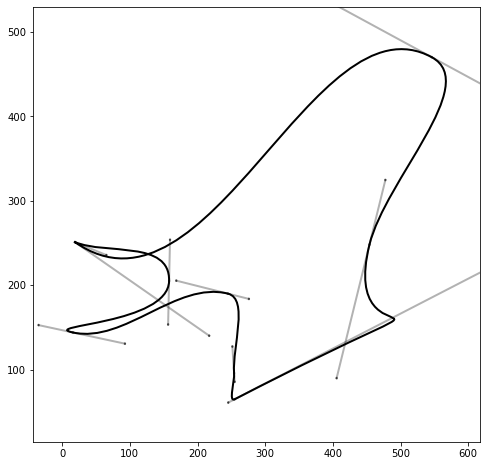

In [29]:
display_curves(curves[curve_num], ) #curve_points

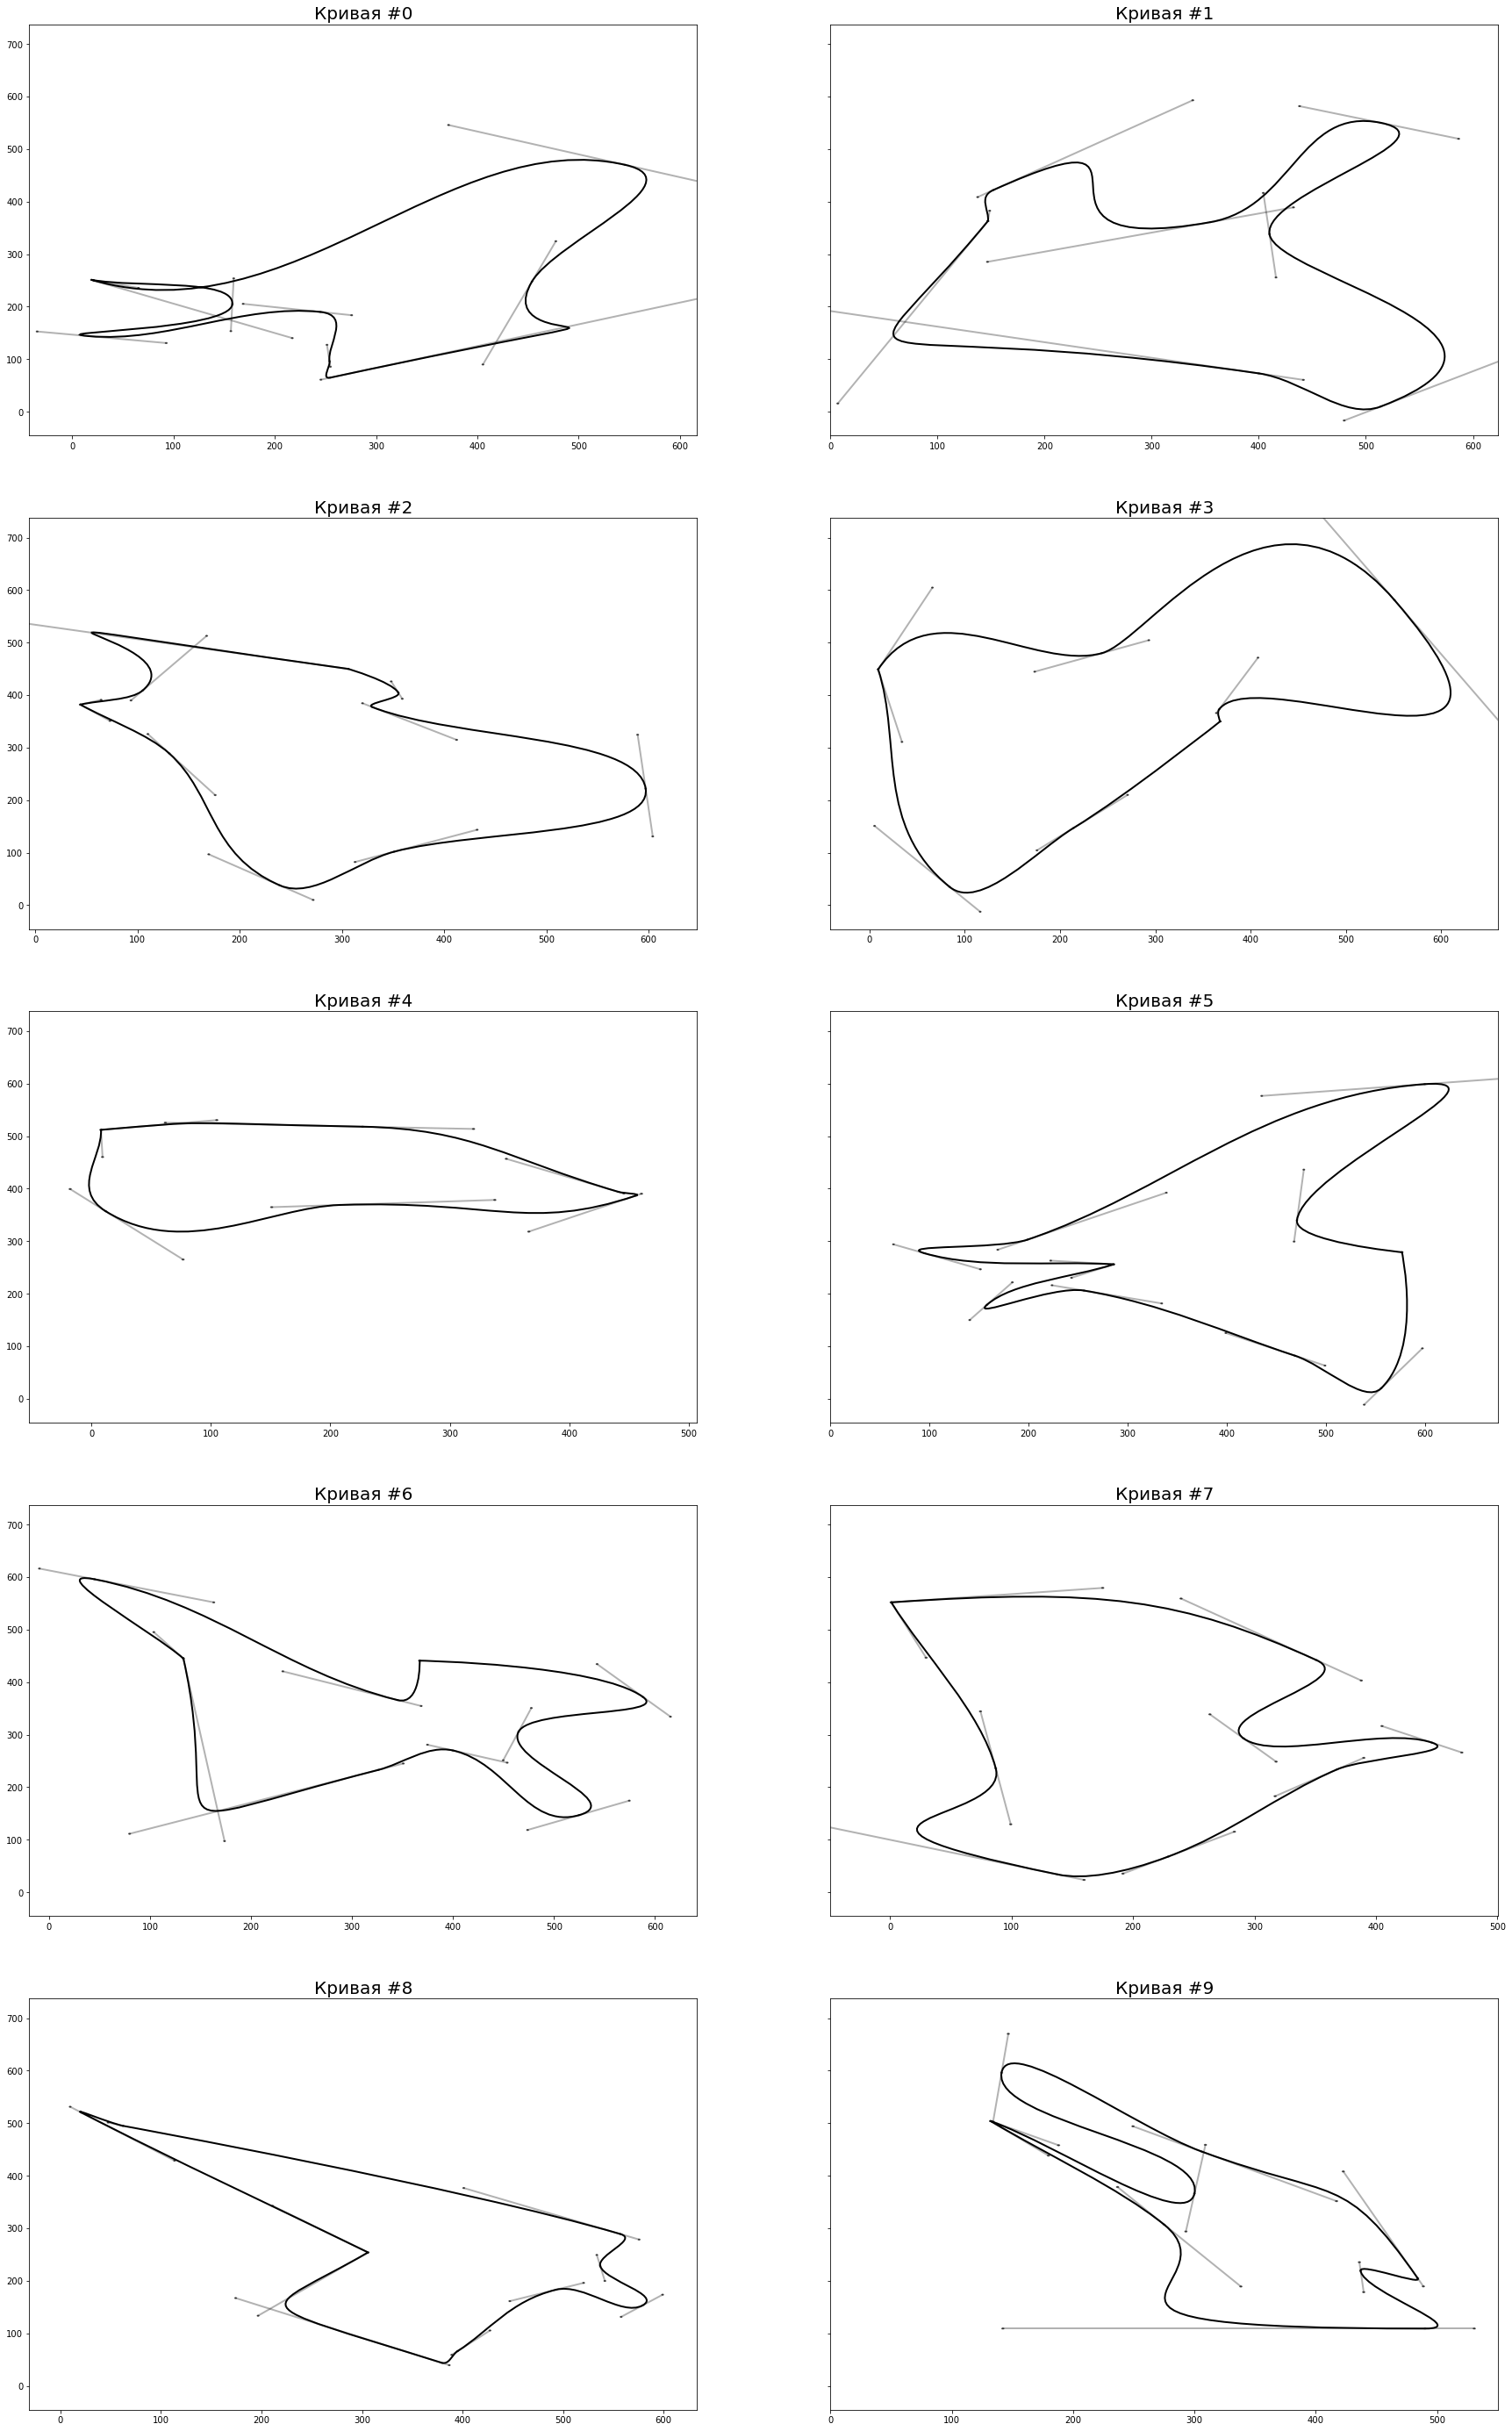

In [57]:
n_rows = 5
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50), sharey=True)
for curve_num, _ in enumerate(curves):
    curve_points = get_curve_as_points(curves[curve_num], num_points=curves[curve_num].length)
    curves[curve_num].plot(axes[int(curve_num // n_cols), int(curve_num % n_cols)])
    axes[int(curve_num // n_cols), int(curve_num % n_cols)].set_title('Кривая #{0}'.format(curve_num)).set_fontsize(20)
plt.show()

In [32]:
3 % 2

1

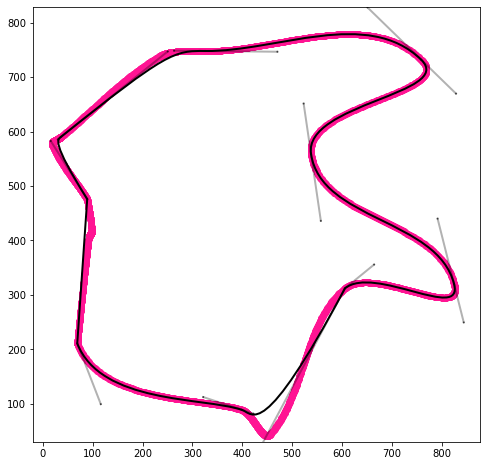

In [83]:
# Removes small and collinear line segments. 
# Small segments (those less than absLength units, 
# or less than relLength as a fraction of the path’s total length) are removed entirely.
curve_prep = curves[curve_num].clone()
curve_prep = curve_prep.removeIrrelevantSegments(relLength=0.06, absLength=0) #1e-02
display_curves(curve_prep, curve_points)

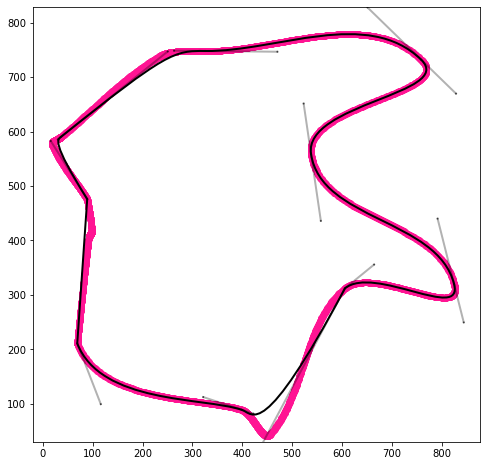

In [84]:
# Smooths a curve, by collating lists of small (at most lengthLimit units long) segments 
# at most maxCollectionSize segments at a time, and running them through a curve fitting algorithm. 
# The list collation also stops when one segment turns more than cornerTolerance degrees 
# away from the previous one, so that corners are not smoothed.
curve_smooth = curve_prep.clone()
curve_smooth = curve_smooth.smooth(maxCollectionSize=10, lengthLimit=50, cornerTolerance=10)
display_curves(curve_smooth, curve_points)